# Translating Emotions from EEG to Visual Arts

We assume at this point that the user has already cloned our repo. First of all, enter it.

In [2]:
%cd Emotions-fromEEG-toArt/

/content/Emotions-fromEEG-toArt


## Install libs

In [ ]:
!pip install torch-scatter \
  torch-sparse \
  torch-cluster \
  torch-spline-conv \
  torch-geometric \
  -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html

In [ ]:
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

## WikiArt

In [5]:
from wikiArt.wikiArt_utils import *

### Import

In [ ]:
!wget http://saifmohammad.com/WebDocs/WikiArt-Emotions.zip
!unzip WikiArt-Emotions.zip
!cp WikiArt-Emotions/WikiArt-Emotions-Ag4.tsv ./
download_wikiArtEmotion("wikiArt/dataset")
!rm -r WikiArt-Emotions
!rm -r __MACOSX/
!rm WikiArt-Emotions-Ag4.tsv
!rm WikiArt-Emotions.zip

### Outliers removal

We provide the user with a list of the selected paintings after our pre-processing steps (wikiArt/selection.pkl). In a future distribution, we will provide the code to reproduce such steps and allow users to personalize their version of the wikiArt dataset.

In [7]:
import pickle
with open('wikiArt/selection.pkl','rb') as f:
  selection=pickle.load(f)

In [8]:
for image in os.listdir("wikiArt/dataset/happiness_optimism"):
  if image not in selection:
    !rm "wikiArt/dataset/happiness_optimism/{image}"

### Data augmentation

In [9]:
for group in os.listdir("wikiArt/dataset"):
  print("{}: {}".format(group,len(os.listdir(os.path.join("wikiArt/dataset",group)))))

sadness_pessimism: 258
anger_disgust: 67
fear_shame: 214
happiness_optimism: 688


In [10]:
data_augmentation("wikiArt/dataset",["anger_disgust","fear_shame","sadness_pessimism"],len(os.listdir("wikiArt/dataset/happiness_optimism")))

In [11]:
for group in os.listdir("wikiArt/dataset"):
  print("{}: {}".format(group,len(os.listdir(os.path.join("wikiArt/dataset",group)))))

sadness_pessimism: 690
anger_disgust: 487
fear_shame: 690
happiness_optimism: 688


### Pre-process

In [12]:
wikiArt_dict=preprocess_wikiart("wikiArt/dataset")
np.save("wikiArt_dict",wikiArt_dict)

### Dataloader

In [13]:
wikiArt_dict=np.load("wikiArt_dict.npy",allow_pickle=True).item()

In [14]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
])

BATCH_SIZE=8
wikiArt_dataloaders = {
    "anger_disgust": torch.utils.data.DataLoader(WikiArtDataLoader(wikiArt_dict["anger_disgust"],transform=transform),batch_size=BATCH_SIZE,shuffle=False,num_workers=0,drop_last=True),
    "sadness_pessimism": torch.utils.data.DataLoader(WikiArtDataLoader(wikiArt_dict["sadness_pessimism"],transform=transform),batch_size=BATCH_SIZE,shuffle=False,num_workers=0,drop_last=True),
    "fear_shame": torch.utils.data.DataLoader(WikiArtDataLoader(wikiArt_dict["fear_shame"],transform=transform),batch_size=BATCH_SIZE,shuffle=False,num_workers=0,drop_last=True),
    "happiness_optimism": torch.utils.data.DataLoader(WikiArtDataLoader(wikiArt_dict["happiness_optimism"],transform=transform),batch_size=BATCH_SIZE,shuffle=False,num_workers=0,drop_last=True)
}

## SEED-IV

In [15]:
from seed_iv.seedIV_utils import *

### Import

We assume at this point that the user has already got the access to the SEED-IV dataset, and imported a .zip file with the following structure:

- **seed-iv.zip**
 - 1.zip
 - 2.zip
 - 3.zip
 - Channel Order.xlsx

In [22]:
!unzip seed-iv.zip -d seed_iv && rm seed-iv.zip
!unzip seed_iv/1.zip -d seed_iv/dataset && rm seed_iv/1.zip
!unzip seed_iv/2.zip -d seed_iv/dataset && rm seed_iv/2.zip
!unzip seed_iv/3.zip -d seed_iv/dataset && rm seed_iv/3.zip

Archive:  seed-iv.zip
 extracting: seed_iv/1.zip           
 extracting: seed_iv/2.zip           
 extracting: seed_iv/3.zip           
  inflating: seed_iv/Channel Order.xlsx  
Archive:  seed_iv/1.zip
  inflating: seed_iv/dataset/1/1_20160518.mat  
  inflating: seed_iv/dataset/1/10_20151014.mat  
  inflating: seed_iv/dataset/1/11_20150916.mat  
  inflating: seed_iv/dataset/1/12_20150725.mat  
  inflating: seed_iv/dataset/1/13_20151115.mat  
  inflating: seed_iv/dataset/1/14_20151205.mat  
  inflating: seed_iv/dataset/1/15_20150508.mat  
  inflating: seed_iv/dataset/1/2_20150915.mat  
  inflating: seed_iv/dataset/1/3_20150919.mat  
  inflating: seed_iv/dataset/1/4_20151111.mat  
  inflating: seed_iv/dataset/1/5_20160406.mat  
  inflating: seed_iv/dataset/1/6_20150507.mat  
  inflating: seed_iv/dataset/1/7_20150715.mat  
  inflating: seed_iv/dataset/1/8_20151103.mat  
  inflating: seed_iv/dataset/1/9_20151028.mat  
Archive:  seed_iv/2.zip
  inflating: seed_iv/dataset/2/1_20161125.mat  


### Pre-process

In [23]:
labels = emotionDL(eps=0.1)
eeg_dict=load_data("seed_iv/dataset",labels)
np.save("eeg_dict",eeg_dict)

In [24]:
for p in eeg_dict.keys():
  print("\nPATIENT {}".format(p))
  print("neutral:\ttrain: {:d}\tval: {:d}".format(len(eeg_dict[p]["neutral"]["train"]),len(eeg_dict[p]["neutral"]["val"])))
  print("sadness:\ttrain: {:d}\tval: {:d}".format(len(eeg_dict[p]["sadness"]["train"]),len(eeg_dict[p]["sadness"]["val"])))
  print("fear:\t\ttrain: {:d}\tval: {:d}".format(len(eeg_dict[p]["fear"]["train"]),len(eeg_dict[p]["fear"]["val"])))
  print("happiness:\ttrain: {:d}\tval: {:d}".format(len(eeg_dict[p]["happiness"]["train"]),len(eeg_dict[p]["happiness"]["val"])))


PATIENT 1
neutral:	train: 448	val: 230
sadness:	train: 432	val: 251
fear:		train: 419	val: 196
happiness:	train: 388	val: 141

PATIENT 6
neutral:	train: 448	val: 230
sadness:	train: 432	val: 251
fear:		train: 419	val: 196
happiness:	train: 388	val: 141

PATIENT 4
neutral:	train: 448	val: 230
sadness:	train: 432	val: 251
fear:		train: 419	val: 196
happiness:	train: 388	val: 141

PATIENT 11
neutral:	train: 448	val: 230
sadness:	train: 432	val: 251
fear:		train: 419	val: 196
happiness:	train: 388	val: 141

PATIENT 5
neutral:	train: 448	val: 230
sadness:	train: 432	val: 251
fear:		train: 419	val: 196
happiness:	train: 388	val: 141

PATIENT 8
neutral:	train: 448	val: 230
sadness:	train: 432	val: 251
fear:		train: 419	val: 196
happiness:	train: 388	val: 141

PATIENT 10
neutral:	train: 448	val: 230
sadness:	train: 432	val: 251
fear:		train: 419	val: 196
happiness:	train: 388	val: 141

PATIENT 7
neutral:	train: 448	val: 230
sadness:	train: 432	val: 251
fear:		train: 419	val: 196
happiness:	tr

### Dataloader

In [25]:
eeg_dict=np.load("eeg_dict.npy",allow_pickle=True).item()

In [ ]:
adjacency_matrix=get_adjacency_matrix("seed_iv/Channel Order.xlsx","seed_iv/Channel Location.txt")
adjacency_matrix=torch.tensor(adjacency_matrix, dtype=torch.float32)

In [27]:
BATCH_SIZE=8
eeg_dataloaders = {}
for p in eeg_dict.keys():
  eeg_dataloaders[p]={
    "neutral": {
      "train": torch_geometric.data.DataLoader(eeg_dict[p]["neutral"]["train"],batch_size=BATCH_SIZE,shuffle=False,drop_last=True),
      "val": torch_geometric.data.DataLoader(eeg_dict[p]["neutral"]["val"],batch_size=BATCH_SIZE,shuffle=False,drop_last=True)
    },
    "sadness": {
      "train": torch_geometric.data.DataLoader(eeg_dict[p]["sadness"]["train"],batch_size=BATCH_SIZE,shuffle=False,drop_last=True),
      "val": torch_geometric.data.DataLoader(eeg_dict[p]["sadness"]["val"],batch_size=BATCH_SIZE,shuffle=False,drop_last=True)
    },
    "fear": {
      "train": torch_geometric.data.DataLoader(eeg_dict[p]["fear"]["train"],batch_size=BATCH_SIZE,shuffle=False,drop_last=True),
      "val": torch_geometric.data.DataLoader(eeg_dict[p]["fear"]["val"],batch_size=BATCH_SIZE,shuffle=False,drop_last=True)
    },
    "happiness": {
      "train": torch_geometric.data.DataLoader(eeg_dict[p]["happiness"]["train"],batch_size=BATCH_SIZE,shuffle=False,drop_last=True),
      "val": torch_geometric.data.DataLoader(eeg_dict[p]["happiness"]["val"],batch_size=BATCH_SIZE,shuffle=False,drop_last=True)
    }
  }

## Training

In [28]:
PATIENT=15

### RGNN

In [29]:
from rgnn.RGNN_utils import *

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/content/Emotions-fromEEG-toArt/rgnn/RGNN_utils.py:167: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2611: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch [0], KL: 21.4349 L1Reg: 0.2018 Total: 21.6367 
Epoch [1], KL: 1.9027 L1Reg: 0.2030 Total: 2.1056 
Epoch [2], KL: 0.3928 L1Reg: 0.2091 Total: 0.6019 
Epoch [3], KL: 0.3368 L1Reg: 0.2109 Total: 0.5477 
Epoch [4], KL: 0.3046 L1Reg: 0.2117 Total: 0.5163 
Epoch [5], KL: 0.3006 L1Reg: 0.2121 Total: 0.5128 
Epoch [6], KL: 0.2887 L1Reg: 0.2124 Total: 0.5011 
Epoch [7], KL: 0.2794 L1Reg: 0.2122 Total: 0.4917 
Epoch [8], KL: 0.2693 L1Reg: 0.2119 Total: 0.4812 
Epoch [9], KL: 0.2656 L1Reg: 0.2115 Total: 0.4771 
Epoch [10], KL: 0.2579 L1Reg: 0.2111 Total: 0.4690 
Epoch [11], KL: 0.2514 L1Reg: 0.2105 Total: 0.4619 
Epoch [12], KL: 0.2728 L1Reg: 0.2102 Total: 0.4830 
Epoch [13], KL: 0.2649 L1Reg: 0.2096 Total: 0.4744 
Epoch [14], KL: 0.2498 L1Reg: 0.2089 Total: 0.4587 
Epoch [15], KL: 0.2474 L1Reg: 0.2082 Total: 0.4555 
Epoch [16], KL: 0.2455 L1Reg: 0.2077 Total: 0.4532 
Epoch [17], KL: 0.2480 L1Reg: 0.2069 Total: 0.4549 
Epoch [18], KL: 0.2513 L1Reg: 0.2062 Total: 0.4575 
Epoch [19], KL: 0.25

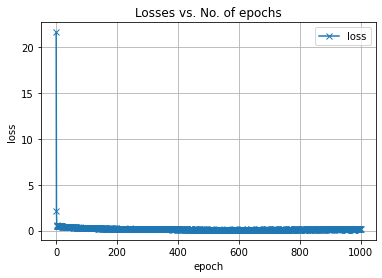

In [30]:
N_EPOCHS=1000

classifier = SymSimGCNNet(62, True,torch.tensor(adjacency_matrix, dtype=torch.float32), 5, (50, 50), 4, 2, dropout=0.7)
classifier = classifier.to(device)
history, best_model_dict = training_routine(classifier, N_EPOCHS,
  EEG_Sampler([
    v["train"] for v in eeg_dataloaders[PATIENT].values()
  ]),
  EEG_Sampler([
    v["val"] for v in eeg_dataloaders[PATIENT].values()
  ]),
  "./checkpoints"
)
plot_history(history)
classifier.load_state_dict(best_model_dict);

### StyleGAN2-ADA

In [31]:
from stylegan2.run_stylegan import *

In [32]:
# Download our alexnet
!python gdrivedl.py https://drive.google.com/open?id=1k8r765crSqarc4FV6aRTxbZZWpNaV3Gw checkpoints/

checkpoints/alexnet.pth
[==================================================] 217.52MB/217.52MB


In [ ]:
args = AttrDict()
args.ckpt = None
args.pretrainedRGNN = "/content/Emotions-fromEEG-toArt/checkpoints/rgnn.pth"
args.pretrainedALEXNET = "/content/Emotions-fromEEG-toArt/checkpoints/alexnet.pth"
args.patient = PATIENT
args.output_folder = "./output"

run_stylegan(args,eeg_dataloaders,wikiArt_dataloaders)